<img src="VSM_logo.gif" width="500" align="center">

# Campi Flegrei caldera (Italy) 

## 2011-2013 InSAR and GNSS modelling

**VSM - Volcanic and Seismic source Modelling** is a Python tool to perform inversions of geodetic data.

**Code** https://github.com/EliTras/VSM \
**License** E. Trasatti - INGV (elisa.trasatti@ingv.it), covered by GNU-GPL License https://github.com/EliTras/VSM/blob/main/license.lic

This Notebook contains details on the use of VSM to run data inversion, and post-processing

Details of the run
- Analytical forward model: sill-like source
- Sampling algorithm: Neighbourhood Algorithm

In [1]:
import os

### Filename

In [2]:
# path of the working folder
folder_inout = './'
filename_in = 'VSM_input_sill.txt'

## Input data
Input data may be either displacements (m) or velocities (m/yr). If more than an input file is considered, of course the unit must be the same (all displacements or all velocities). For all datapoints, *East* and *North* are the coordinates (metric, preferred system is projected UTM).
Accepted data types are
- InSAR
- GNSS
- Levelling
- EDM
- Tilt
- Strain

### InSAR
This data refers to InSAR data, both single inferterograms or multi-temporal InSAR. Results are typycally in terms of cumulative displacements or annual velocities. The InSAR maps are usually made of thounsands of pixels so it is needed to downsample the dataset first. VSM uses downsampled InSAR datasets.
- up to 10 datasets from different sensors or missions
- a single data file is inserted as ` path/sarfile.txt `
- for multiple datasets just leave a blank between fullpath names ` path/sarfile1.txt path/sarfile2.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefile (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data Error LOS_E LOS_N LOS_Z
       
where *Data* is the LOS (Line of Sight) displacement or velocity. *LOS_E*, *LOS_N*, *LOS_Z* are the East, North and vertical components of the versor of the Line of Sight of the sensor.

### GNSS
GNSS data are typically composed of 3D displacement or mean velocity at each benchmark.
- the data file is inserted as ` path/gpsfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- one row for each station
- format of columns
       East North Data_E Data_N Data_Z Error_E Error_N Error_Z

where *Data_E* is the East component of the displacement or velocity. Same applies to the North (N) and vertical (Z) components and to the error associated.

### Levelling
Levelling data are the difference in the elevation of benchmarks in a given time window.
- the data file is inserted as ` path/levfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data Error

where *Data* is the different of elevation in the given time period.

### EDM
EDM (Electro-optical Distance Measuring) technique measures the difference in the horizontal position between two benchmarks.
- the data file is inserted as ` path/edmfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East1 North1 East2 North2 Data Error

Each row lists the coordinates of the start (1) and end (2) benchmarks. *Data* is one single value, representing the change in the distance between two benchmarks in a given time widow.

### Tilt
Tilt is a measure of the displacement gradient. It is the inclination of the vertical along a horizontal direction. The horizontal derivatives of the vertical deformation correspond to the East and North components of tilt. 
- the data file is inserted as ` path/tiltfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data_E Data_N Error_E Error_N

where *Data_E* and *Data_N* are the tilt along East (E) and North (N) directions, and the associated error. If the tiltmeter is not oriented along East or North, data should be projected accordingly. Tilt is non-dimensional and the unit in VSM is microradians (ppm).

### Strain
Strain is a measure of the displacement gradient. The volumetric strain is the unit change in volume, i.e. it combines the change of the displacement in the three components. 
- the data file is inserted as ` path/strainfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data Error

Strain is non-dimensional and the unit in VSM is microstrains (ppm).

In [3]:
#Add the input files. By default all file names are 'None'. Set to 'None those unused'

# SAR filename(s)
sar_file = '../DATA/obs_sar1.txt ../DATA/obs_sar2.txt'
#GNSS filename
gps_file = '../DATA/GPS_data.txt'
# levelling filename
lev_file = 'None'
# EDM filename
edm_file = 'None'
#tilt filename
tlt_file = 'None'
# strain filename
srn_file = 'None'

### Weights

In [4]:
# SAR weight
sar_weight = 1.
# GNSS weight
gps_weight = 1.
# levelling weight
lev_weight = 0.
# EDM weight
edm_weight = 0.
# tilt weight
tlt_weight = 0.
# strain weight
srn_weight = 0.

In [5]:
f = open(os.path.join(folder_inout,filename_in), "w")
f.write(folder_inout+'\n')
f.write(sar_file+'\n'+gps_file+'\n'+lev_file+'\n'+edm_file+'\n'+tlt_file+'\n'+srn_file+'\n')
f.write(str(sar_weight)+'\n'+str(gps_weight)+'\n'+str(lev_weight)+'\n'+str(edm_weight)+'\n'+str(tlt_weight)+'\n'+str(srn_weight)+'\n');

### Forward model

In [6]:
import numpy as np

# shear modulus (Pa)
mu = 5e9
# Poisson ratio
ni = 0.25

# number of sources
num_sources = 1

# write this part in the input file
f.write(str(mu)+'\n')
f.write(str(ni)+'\n')
f.write(str(num_sources)+'\n');

### Definition of forward model

Define the sources with the range of search for each parameter. For each chosen source it must be reported the list of the parameters with minimum and maximum (minimum $<=$ maximum). To fix a parameter, just choose minimum and maximum equal to the desired value. 

Each forward model is identified by a number from 0 to 5. Below are reported details on parameters and a sample of instructions to copy and paste in the code cells. The depth is positive.

#### Mogi Point Source
**Model 0** The Mogi (1958) point source model represents an isotropic point source. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source source center
- Volume variation

*Code* \
`east = (0,0)` \
`north = (0,0)` \
`depth  = (0,0)` \
`Dvol  = (0,0)` \
`bounds = [east, north, depth, Dvol] `

#### Mogi Finite Volume
**Model 1** The McTigue (1987) finite volume model is an evolution of the Mogi model and represents a spherical source with finite volume. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- Radius of the sphere
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)

*Note* \
$\Delta P/ \mu$ is adimensional.

*Code* \
`east = (0,0)` \
`north = (0,0)` \
`depth  = (0,0)` \
`radius  = (0,0)` \
`DP_mu  = (0,0)` \
`bounds = [east, north, depth, radius, DP_mu] `

#### Penny-shaped crack
**Model 2** The penny shaped crack (Fialko et al., 2001) is a disk with a radius and no vertical extension. Parameters:
- East coordinate of the disk center
- North coordinate of the disk center
- Depth of the disk center
- Radius of the disk
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)

*Note* \
$\Delta P/ \mu$  is adimensional.

*Code* \
`east = (0,0)` \
`north = (0,0)` \
`depth  = (0,0)` \
`radius  = (0,0)` \
`DP_mu  = (0,0)` \
`bounds = [east, north, depth, radius, DP_mu] `

#### Spheroid
**Model 3** The spheroid (Yang et al., 1988) is a finite-volume cavity with a constant overpressure on the boundary. It can be arbitrarily oriented in space Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- Semi-major axis
- Ratio of semi-minor vs semi-major axes
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)
- Strike angle
- Dip angle

*Note* \
The ratio is < 1. $\Delta P/ \mu$  is adimensional. The strike is considered according to Yang et al. (1988), i.e., degrees clockwise from East. It means if the spheroid dips to East the strike = 0°, if it dips to North the strike = 90° etc. The dip angle is 0° = horizontal 90°= vertical.

*Code* \
`east = (0,0)` \
`north = (0,0)` \
`depth  = (0,0)` \
`axis  = (0,0)` \
`ratio  = (0,0)` \
`DP_mu  = (0,0)` \
`strike  = (0,0)` \
`dip  = (0,0)` \
`bounds = [east, north, depth, axis, ratio, DP_mu, strike, dip] `

#### Moment tensor
**Model 4** The moment tensor source (Davis, 1986) is a general point source defined by a combination of dipoles and double forces, P$_{ij}$. The diagonal elements of the P$_{ij}$ matrix are the dipoles, and the off-diagonal are the double-couples according to cartersian coordinates. It may represent a sphere (three equal dipoles), a dislocation (double couple), and a subset of the possible combination of the component may represent an equivalent triaxial elliposid arbitrary oriented. The P$_{ij}$ matrix must be interpreted following the tables in Davis (1986), to find the aspect ratio of the equivalent ellipsoid and its orientation. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- P$_{xx}$
- P$_{yy}$
- P$_{zz}$
- P$_{xy}$
- P$_{yz}$
- P$_{zx}$

*Note* \
According to Davis (1986), the P$_{ij}$ matrix is expressed in Pa multiplied by volume vs shear modulus.

*Code* \
`east = (0,0)` \
`north = (0,0)` \
`depth  = (0,0)` \
`Pxx  = (0,0)` \
`Pyy  = (0,0)` \
`Pzz  = (0,0)` \
`Pxy  = (0,0)` \
`Pyz  = (0,0)` \
`Pzx  = (0,0)` \
`bounds = [east, north, depth, Pxx, Pyy, Pzz, Pxy, Pyz, Pzx] `

#### Rectangular dislocation
**Model 5** The  dislocation model (Okada, 1985) is a rectangular plane undergoing shear slip (along dip and/or strike) and/or tensile opening/closing. Two configurations are available. The first one considers strike-slip and dip-slip on the fault plane, while the other uses the total slip and the rake angle. Parameters:
- East coordinate of the top left corner
- North coordinate of the top left corner
- Depth of the top
- Length
- Width
- Strike angle
- Dip angle
- Strike-slip, or, conversely, total slip
- Dip-slip, or, conversely, rake angle
- Tensile movement

*Note* \
The strike angle is the orientation of the plane seen from the top left corner and it is measured according to Okada (1985), from North counter-clockwise, i.e., strike = 0° if the fault plane is oriented North-South and dips to East, strike = 90° if the fault is East-West trending and dips to the South, etc. The tensile movement is > 0 for opening, < 0 for closure.
Must specify also 'S' for strike and dip slip, 'R' for total slip and rake (for the generic param1 and param2).

*Code* \
`east = (0,0)` \
`north = (0,0)` \
`depth  = (0,0)` \
`length  = (0,0)` \
`width  = (0,0)` \
`strike  = (0,0)` \
`dip  = (0,0)` \
`param1  = (0,0)` \
`param2  = (0,0)` \
`opening  = (0,0)` \
`bounds = [east, north, depth, length, width, strike, dip, param1, param2, opening] `

In [7]:
# define the source identifier of the forward model
# 0=Mogi 1=McTigue 2=Sill 3=Spheroid 4=Ellipsoid 5=Fault/Dike
# comment or uncomment the lines needed, based on the number of sources employed
sorg_identifier = 2
#parameters minimum and maximum (minimum <= maximum)
param1 = (422000., 432000.)
param2 = (4515000., 4525000.)
param3 = (2000., 7000.)
param4 = (1000., 1000.)
param5 = (1e-4, 1e-2)
bounds = [param1,param2,param3,param4,param5]

#Uncomment and define the style ('S' or 'R') in case of Okada (Fault/Dike source)
#okada_mode = 'S'

# write this part in the input file
if(sorg_identifier!= 5):
    f.write(str(sorg_identifier)+'\n')
else:
    f.write(str(sorg_identifier)+' '+okada_mode+'\n')
       
for k in range(len(bounds)):
    row = str(list(bounds[k])[0])+'\t'+str(list(bounds[k])[1])+'\n'
    f.write(row)

## VSM settings

### Inversion algorithms
There are two inversion tools included in VSM
- **NA** is the **Neighbourhood Algorithm**, a global optimizer based on the Voronoi cells theory for the sampling (Sambridge, 1999). The parameters needed are:
    - number of samples at each iteration `sampl1`
    - number of re-samples from each iteration `sampl2`
    - number of iterations `sampl3`
- **BI** is the **Bayesian Inference**, an inversion tool based on the Bayes theory and MCMC sampling. The parameters needed are:
    - number of random walks `sampl1`
    - number of steps for each random walk `sampl2`

In [8]:
# inversion choice NA = 0 BI = 1
inversion_choice = 0
# accordingly define the sampling parameters
sampl1 = 1000
sampl2 = 300
sampl3 = 12

f.write(str(inversion_choice)+'\n')
if(inversion_choice == 0):
    f.write(str(sampl1)+' '+str(sampl2)+'\n')
    f.write(str(sampl3)+'\n')
else:
    f.write(str(sampl1)+'\n')
    f.write(str(sampl2)+'\n')

### Plots

In [9]:
# Number of burn-in models. Default is 2000. No plots for -1
num_skip = 5000
f.write(str(num_skip)+'\n');

In [10]:
# END of settings for the VSM input!
f.close()

## Launch VSM

In [11]:
import sys
sys.path.append('../../VSM')

import VSM


In [12]:
# Read VSM input
VSM.read_VSM_settings(os.path.join(folder_inout,filename_in))



*******************************************************************************

                   VSM exectution begins

Start reading settings of VSM from input file -->
./VSM_input_sill.txt 

Data -->
InSAR data file # 1 ../DATA/obs_sar1.txt
SAR data file # 2 ../DATA/obs_sar2.txt
GNSS data file ../DATA/GPS_data.txt

Source 1 considered -->
 Penny-shaped crack (Fialko et al., 2001)

There are 5 total free parameters
Parameters actually inverted -->  4
xcen (422000.0, 432000.0)
ycen (4515000.0, 4525000.0)
depth (2000.0, 7000.0)
dP_mu (0.0001, 0.01)

Inversion tool chosen --> NEIGHBOURHOOD ALGORITHM
N. of samples:  1000 N. of re-samples 300
N. of iterations:  12

Number of burn-in samples for the plots --> 5000 





Reading data...
Found  2713 InSAR data in dataset # 1
Found  2817 InSAR data in dataset # 2
Found  14 GPS data

Output folder is -->
 ./

                    All input read

*******************************************************************************

NEIGHBOURHOOD ALGORITM running...
Searcher(iteration=1, samples=1000, best=6.459234e+01)
Searcher(iteration=2, samples=2000, best=2.351586e+01)
Searcher(iteration=3, samples=3000, best=2.351586e+01)
Searcher(iteration=4, samples=4000, best=2.351586e+01)
Searcher(iteration=5, samples=5000, best=2.192770e+01)
Searcher(iteration=6, samples=6000, best=2.064141e+01)
Searcher(iteration=7, samples=7000, best=2.058764e+01)
Searcher(iteration=8, samples=8000, best=2.027291e+01)
Searcher(iteration=9, samples=9000, best=2.027291e+01)
Searcher(iteration=10, samples=10000, best=2.020620e+01)
Searcher(iteration=11, samples=11000, best=2.020620e+01)
Searcher(iteration=12, samples=12000, best=2.020368e+01)

BEST-FIT PARAMETERS
 [4.26223980e+05 4.5186

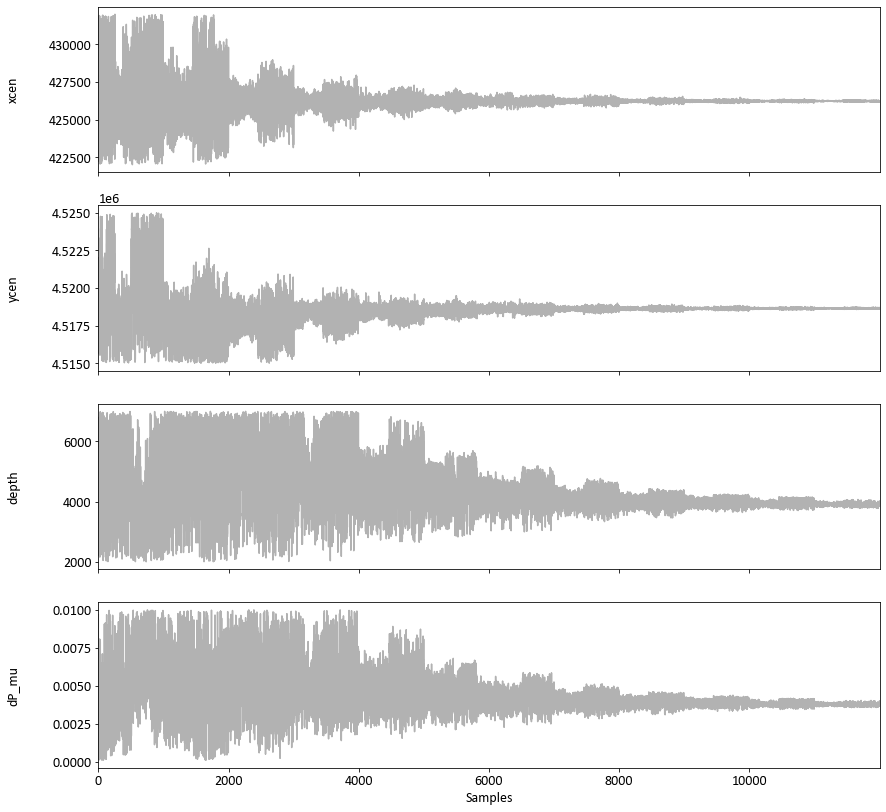

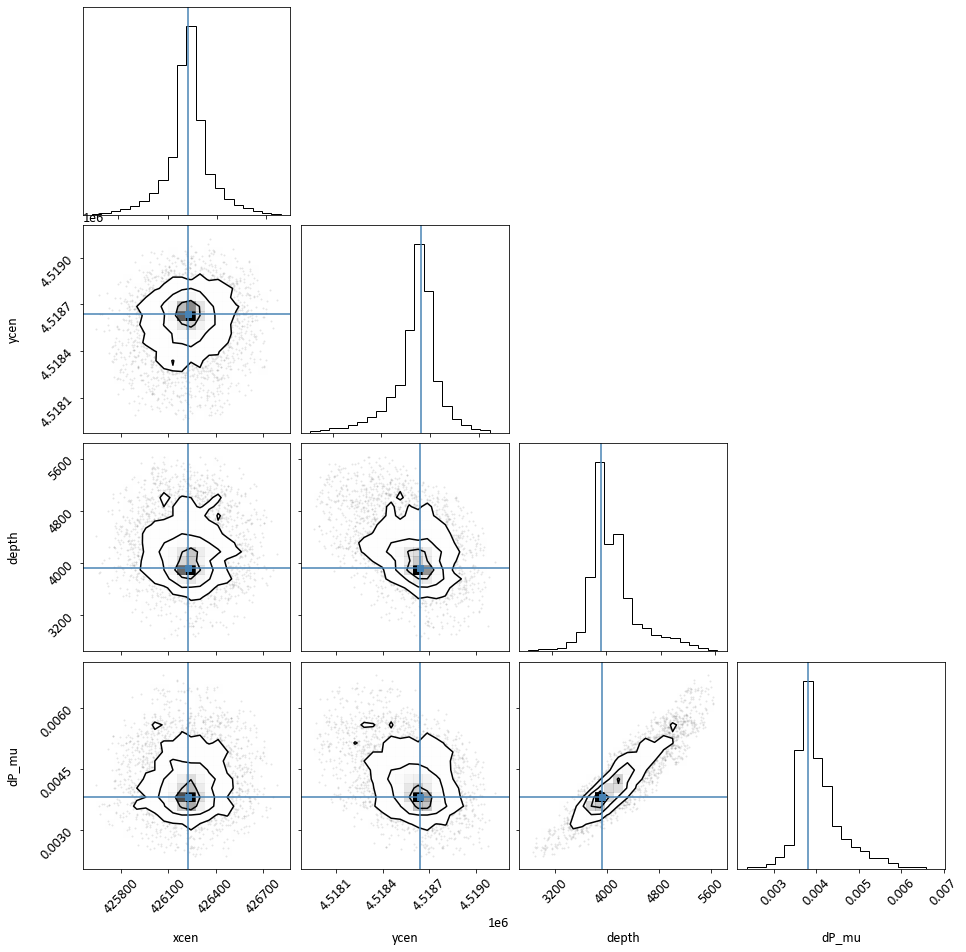

In [13]:
# Run VSM
VSM.iVSM()

## Post Processing

In [14]:
import VSM_utilities as VSMU
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Plot Data, model and residuals

In [15]:
synth_file = 'VSM_synth_sar1.csv'
out_file = 'VSM_res_sar1.png'

# UTM zone
zone = 33
southern_hemisphere = False

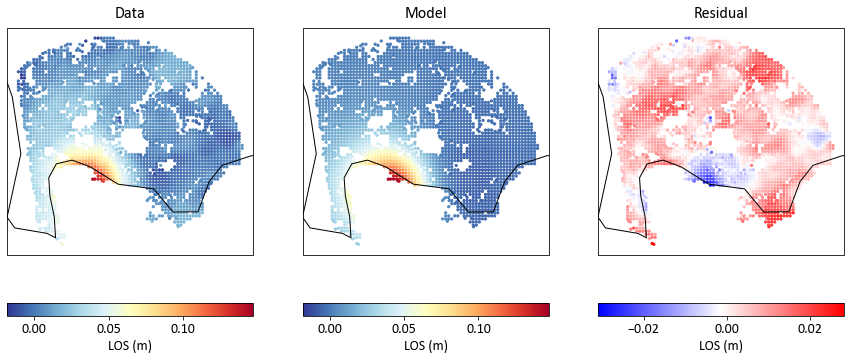

In [18]:
# My data in UTM coordinates
db_sar = pd.read_csv(os.path.join(folder_inout,synth_file))
d_sar = db_sar.values

# Split into east and north coordinates
east, north = d_sar[:,0],d_sar[:,1]
data = d_sar[:,3]
synth = d_sar[:,2]
res = data - synth

dmax = max(max(data),max(synth))
dmin = min(min(data),min(synth))
resmax = max(res)
resmin = min(res)
resext = max(resmax, -resmin)

# Define the projection
#crs=ccrs.PlateCarree()
mycrs=ccrs.UTM(zone=zone, southern_hemisphere=southern_hemisphere)

fig=plt.figure(figsize=(15,6))

## PANEL DATA ##########
ax = plt.subplot(131, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data, cmap="RdYlBu_r", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Data',fontsize = 16, pad=10)

## PANEL MODEL ##########
ax = plt.subplot(132, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, synth,cmap="RdYlBu_r", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Model',fontsize = 16, pad=10)

## PANEL RESIDUALS ##########
ax = plt.subplot(133, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data - synth,cmap="bwr",vmin=resext, vmax = -resext)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
# Title for plot
plt.title('Residual',fontsize = 16, pad=10)

plt.savefig(os.path.join(folder_inout,out_file))
plt.show()

In [19]:
synth_file = 'VSM_synth_sar2.csv'
out_file = 'VSM_res_sar2.png'

# UTM zone
zone = 33
southern_hemisphere = False

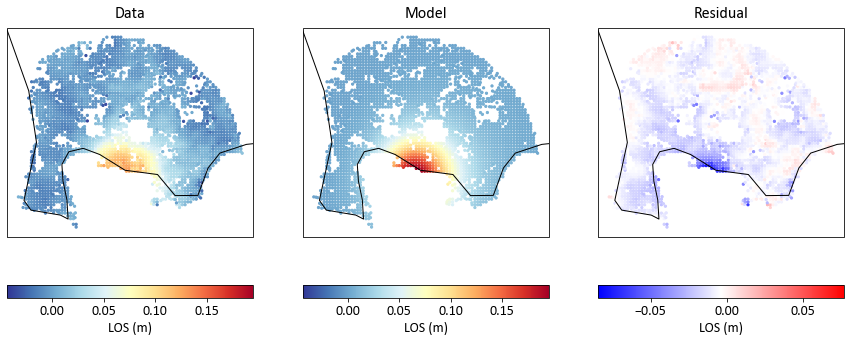

In [20]:
# My data in UTM coordinates
db_sar = pd.read_csv(os.path.join(folder_inout,synth_file))
d_sar = db_sar.values

# Split into east and north coordinates
east, north = d_sar[:,0],d_sar[:,1]
data = d_sar[:,3]
synth = d_sar[:,2]
res = data - synth

dmax = max(max(data),max(synth))
dmin = min(min(data),min(synth))
resmax = max(res)
resmin = min(res)
resext = max(resmax, -resmin)

# Define the projection
#crs=ccrs.PlateCarree()
mycrs=ccrs.UTM(zone=zone, southern_hemisphere=southern_hemisphere)

fig=plt.figure(figsize=(15,6))

## PANEL DATA ##########
ax = plt.subplot(131, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data, cmap="RdYlBu_r", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Data',fontsize = 16, pad=10)

## PANEL MODEL ##########
ax = plt.subplot(132, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, synth,cmap="RdYlBu_r", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Model',fontsize = 16, pad=10)

## PANEL RESIDUALS ##########
ax = plt.subplot(133, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data - synth,cmap="bwr",vmin=resext, vmax = -resext)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
# Title for plot
plt.title('Residual',fontsize = 16, pad=10)

plt.savefig(os.path.join(folder_inout,out_file))
plt.show()